# Properties of LDLJ-A measures

This notebook contains the code for generating the plots demonstrating the properties of the LDLJ-A measure, along with the plots for LDLJ-V and SPARC.

**Note**: To execute this code change the variable "basedrive" to the correct folder addresss.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [0]:
import json
import glob
import sys
import pandas as pd
import os

basedrive = "drive/My Drive/0_projects/IMU-Smoothness"
os.chdir(basedrive)
sys.path.append("scripts")

In [0]:
import pandas as pd
import datetime

# Matplotlib settings
mpl.rcParams['svg.fonttype'] = 'none'

In [0]:
import sys
sys.path.append("../scripts/")
from imupaper.for_imupaper import generate_simulated_movements
from imupaper.for_imupaper import ldlj_vel_accl_terms
from imupaper.for_imupaper import sparc_vel_accl_terms
from imupaper.for_imupaper import ldlj_vel_vs_accl
from smoothness import log_dimensionless_jerk as ldlj
from smoothness import sparc

In [0]:
from smoothness import log_dimensionless_jerk_factors as ldlj_facs

In [0]:
import matplotlib.gridspec as gridspec

## Consistency of the LDLJ-A measure

In [0]:
Ns = [2, 4, 8]
Ts = 1.0
_dT = 0.025
dT = np.arange(0, 2 * Ts + _dT, _dT)
ts = 0.001
# Out dir
outdir = "data/ldlj_compare/"

In [0]:
# Generate movements
moves = generate_simulated_movements(Ns, dT, Ts, ts, move_type='gaussian')

# Save movement data
for k in ('vel', 'accl', 'jerk'):
    for i in range(len(moves[k])):
        _fname = f"{outdir}/gaussian_{k}_{Ns[i]}.json"
        with open(_fname, 'w') as fh:
            json.dump({'dT': list(dT), 'data': [list(m) for m in moves[k][i]]},
                      fh, sort_keys=True, indent=4, separators=(',', ': '))
        sys.stdout.write("\r{0}".format(_fname))
        sys.stdout.flush()

In [0]:
# Calculate LDLJ-V
ldlj_v = np.array([[ldlj(np.array([_d]).T, fs=1/ts, data_type="vel", rem_mean=False)
                    for _d in _data] for _data in moves['vel']])
ldlj_v_facs = np.array([[ldlj_facs(np.array([_d]).T, fs=1/ts, data_type="vel", rem_mean=False)
                         for _d in _data] for _data in moves['vel']])

# Calculate LDLJ-A
ldlj_a = np.array([[ldlj(np.array([_d]).T, fs=1/ts, data_type="accl", rem_mean=True)
                    for _d in _data] for _data in moves['accl']])
ldlj_a_facs = np.array([[ldlj_facs(np.array([_d]).T, fs=1/ts, data_type="accl", rem_mean=True)
                         for _d in _data] for _data in moves['accl']])

# # Calculate LDLJ-V
# ldlj_v = np.array([[ldlj(np.array([_d]).T, fs=1/ts, data_type="vel")
#                     for _d in _data] for _data in moves['vel']])
# ldlj_v_facs = np.array([[ldlj_facs(np.array([_d]).T, fs=1/ts, data_type="vel")
#                          for _d in _data] for _data in moves['vel']])

# # Calculate LDLJ-A
# ldlj_a = np.array([[ldlj(np.array([_d]).T, fs=1/ts, data_type="vel")
#                     for _d in _data] for _data in moves['jerk']])
# ldlj_a_facs = np.array([[ldlj_facs(np.array([_d]).T, fs=1/ts, data_type="vel")
#                          for _d in _data] for _data in moves['jerk']])

In [0]:
# Calculate SPARC with velocity
sparc_v = np.array([[sparc(_d, fs=1/ts)[0]
                     for _d in _data] for _data in moves['vel']])

In [0]:
# Calculate SPARC with acceleration
sparc_a = np.array([[sparc(_d, fs=1/ts)[0]
                     for _d in _data] for _data in moves['accl']])

In [0]:
fig = ldlj_vel_accl_terms(ldlj_v, ldlj_v_facs, ldlj_a, ldlj_a_facs, dT)
fig.savefig(fname="data/ldlj_compare/ldlj-terms.svg", format="svg")
fig.savefig(fname="data/ldlj_compare/ldlj-terms.png", format="png", dpi=300)

## SPARC on velocity and acceleration data



In [0]:
fig = sparc_vel_accl_terms(sparc_v, sparc_a, dT)
fig.savefig(fname="data/ldlj_compare/sparc-vel-accl.svg", format="svg")
fig.savefig(fname="data/ldlj_compare/sparc-vel-accl.png", format="png", dpi=300)

## Generate LDLJ-V and LDLJ-A for random 3D movements

In [0]:
# Data directory
data_dir = "data/mjtdata/"

# Other parameters.
T = 1.0
dt = T / 1000.
Fs = 1 / dt

In [9]:
files = glob.glob(f"{data_dir}/*.csv")
ldlj_v = np.zeros(len(files))
ldlj_a = np.zeros(len(files))
for i, f in enumerate(files):
  sys.stdout.write(f"\r Move {i}/{len(files)}")
  sys.stdout.flush()
  data = pd.read_csv(f)
  ldlj_v[i] = ldlj(np.array(data.loc[:, ['vx', 'vy', 'vz']]),
                   fs=Fs, data_type="vel", rem_mean=False)
  ldlj_a[i] = ldlj(np.array(data.loc[:, ['ax', 'ay', 'az']]),
                   fs=Fs, data_type="accl", rem_mean=True)

 Move 250/251

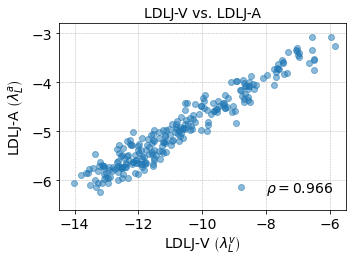

In [10]:
fig = ldlj_vel_vs_accl(ldlj_v, ldlj_a)
fig.savefig(fname="data/ldlj_compare/ldlj-compare.svg", format="svg")
fig.savefig(fname="data/ldlj_compare/ldlj-compare.png", format="png", dpi=300)